# Team Panda | data anonymisation and security sharing project
iInsureU123, a health insurance start-up, consulting us for data anonymisation and security sharing. 

## Setting up the environment

### Importing packages and data

In [221]:
# Importing packages
import random
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime
import pycountry_convert as pc
import seaborn as sns
sns.set()
# Importing the data
data = pd.read_csv('customer_information.csv')

### Functions

In [222]:
# Function to see the distribution in each variable
def plot_column_counts_with_annotations(data, variable, rotation_degree=0):
    # Counting unique values in the specified column
    counts = data[variable].value_counts()
    variable_name = variable.replace("_"," ")
    # Plotting the counts as a bar graph
    ax = counts.plot(kind='bar')
    plt.xlabel(variable_name)
    plt.ylabel("Counts")
    plt.title(f"Distribution of {variable_name}")
    plt.xticks(rotation=rotation_degree)

    # # Annotating the bar graph with the counts
    for i, count in enumerate(counts):
        ax.annotate(str(count), (i, count), ha='center', va='bottom', xytext=(0, 0), textcoords='offset points')

    plt.show()

# Anonymising names into sampleID

In [223]:
def generate_sample_id(index):
    return f"sid_{str(index + 1).zfill(5)}"

data['sample_ID'] = data.index.to_series().apply(generate_sample_id)

# Banding birth year

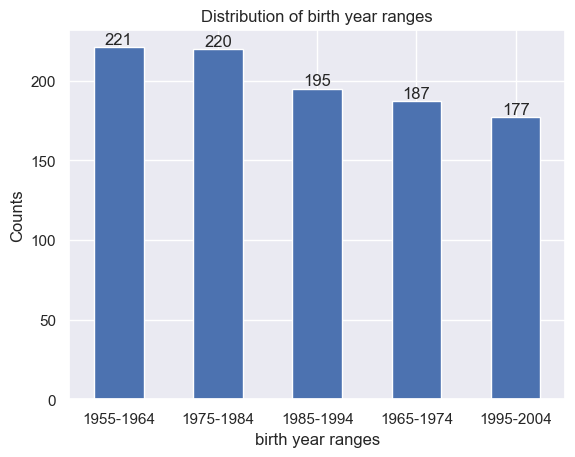

In [224]:
# Converting birth date to birth year
birthDate = pd.to_datetime(data.birthdate, format='mixed')
data['birth_year'] = pd.DatetimeIndex(birthDate).year

# Looking at min and max of birth year
min_birthyear = data['birth_year'].min() # 1955
max_birthyear = data['birth_year'].max() # 2005

# # Assuming you have already created 'birth_year_group'
# group_labels = ['1955-1967', '1968-1979', '1980-1990', '1991-2003']
# data['birth_year_ranges'] = pd.qcut(data['birth_year'], 4, labels=group_labels)

# # Group by the 'birth_year_group' and then find min and max of 'birth year' in each group
# group_ranges = data.groupby('birth_year_ranges')['birth_year'].agg(['min', 'max'])

# print(group_ranges)


# Creating groups with 15 years range
birthyear_bins = ["1955", "1965", "1975", "1985", "1995", "2005"]
birthyear_labels = ["1955-1964", "1965-1974", "1975-1984", "1985-1994", "1995-2004" ]

# Banding heights into specified ranges
data['birth_year_ranges'] = pd.cut(data['birth_year'], bins=birthyear_bins, labels=birthyear_labels, right=False)

# Showing counts of height ranges
plot_column_counts_with_annotations(data, 'birth_year_ranges')


# Banding country of birth to continent of birth

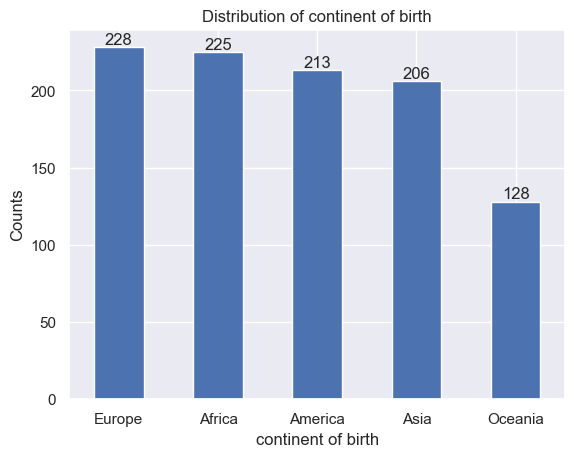

In [225]:
# Dictionary to manually map countries that could not be mapped via pycountry_convert
continent_mapping = {
    'Korea': 'Asia',
    'Western Sahara': 'Africa',
    'Slovakia (Slovak Republic)': 'Europe',
    'Saint Barthelemy': 'North America',
    'Pitcairn Islands': 'Oceania',
    'Holy See': 'Europe',
    'Reunion': 'Africa',
    'United States Minor Outlying Islands': 'North America',
    'Antarctica (the territory South of 60 deg S)': 'Antarctica',
    'Svalbard & Jan Mayen Islands': 'Europe',
    'Bouvet Island (Bouvetoya)': 'Antarctica',
    'Saint Helena': 'Africa',
    "Cote d'Ivoire": 'Africa',
    'British Indian Ocean Territory (Chagos Archipelago)': 'Asia',
    'Palestinian Territory': 'Asia',
    'Libyan Arab Jamahiriya': 'Africa',
    'Timor-Leste': 'Asia',
    'Netherlands Antilles': 'North America',
    'Holy See (Vatican City State)': 'Europe'
}

# Function to map country to continent
def country_to_continent(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        if country_name in continent_mapping:
            return continent_mapping[country_name]
        else:
            return 'Unknown'
        
# Applying the function to map the country to continent
data['continent_of_birth'] = data['country_of_birth'].apply(country_to_continent)
data['continent_of_birth'].replace('North America', 'America', inplace = True)
data['continent_of_birth'].replace('South America', 'America', inplace = True)
data['continent_of_birth'].replace('Antarctica', 'Oceania', inplace = True)

# # # Grouping Americas together and antarctica to oceania
# data['continent_of_birth'].replace('Europe', 'A', inplace = True) # 228
# data['continent_of_birth'].replace('North America', 'A', inplace = True) # 147
# data['continent_of_birth'].replace('Asia', 'B', inplace = True) # 206
# data['continent_of_birth'].replace('Oceania', 'B', inplace = True) # 117
# data['continent_of_birth'].replace('South America', 'A', inplace = True) # 66
# data['continent_of_birth'].replace('Africa', 'B', inplace = True) # 225
# data['continent_of_birth'].replace('Antarctica', 'B', inplace = True) # 11

# continent_labels = ["Europe & North America & Asia & Oceania", "South America & Africa & Antarctica"]

plot_column_counts_with_annotations(data, "continent_of_birth")

# Banding postcodes into regions

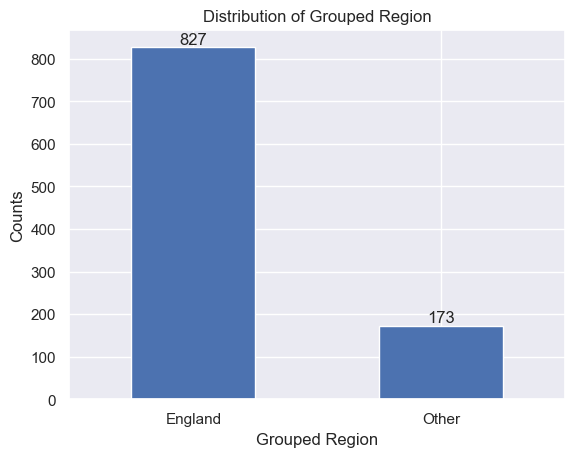

In [226]:
# Function to truncate postcode after the first numeric digit
def truncate_postcode(postcode):
    for i, char in enumerate(postcode):
        if char.isdigit():
            return postcode[:i]  # Truncate at the position of the first numeric digit
    return postcode  # Return the original postcode if no numeric digit is found

# Applying the function to create the postcode bands
data['postcode'] = data['postcode'].astype(str).apply(truncate_postcode)

# Importing postcode mapping to region
postcode_values = pd.read_excel('PostcodeRegions.xlsx')

# Making it into a dictionary
postcode_dict = postcode_values.set_index('Postcode Area')['Region'].to_dict()

# Applying the mapping to the dataframe
data['Region'] = data['postcode'].map(postcode_dict)

# Dictionary for mapping regions to 'England' or 'Other'
region_mapping = {
    'Greater London': 'England',
    'North West': 'England',
    'East Midlands': 'England',
    'West Midlands': 'England',
    'South East': 'England',
    'South West': 'England',
    'East of England': 'England',
    'North East': 'England',
    'East England': 'England',
    'Scotland': 'Other',
    'Wales': 'Other',
    'Channel Islands': 'Other',
    'Northern Ireland': 'Other',
    'Isle of Man': 'Other'
}

# Creating a new column with the mapped values
data['Grouped_Region'] = data['Region'].map(region_mapping)

plot_column_counts_with_annotations(data, 'Grouped_Region')

# Banded education

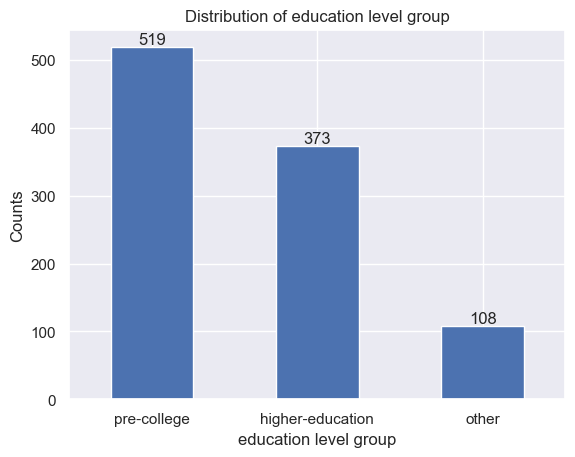

In [227]:
# Grouping Education level together
education_replacements = {
    'primary': 'pre-college',
    'secondary': 'pre-college',
    'bachelor': 'higher-education',
    'masters': 'higher-education',
    'phD': 'higher-education',
    'other': 'other'
}

data['education_level_group'] = data['education_level'].map(education_replacements)

plot_column_counts_with_annotations(data, 'education_level_group')

# Generating final datasets

In [228]:
# Order of columns:
cols_gov = ['sample_ID', 'gender','birth_year_ranges', 'continent_of_birth', 'current_country', 'Grouped_Region', 'weight', 'height', 'blood_group', 'avg_n_drinks_per_week', 'avg_n_cigret_per_week', 'education_level_group', 'n_countries_visited','cc_status']
cols_res = ['sample_ID', 'gender','birth_year', 'continent_of_birth', 'current_country', 'Region', 'weight', 'height', 'blood_group', 'avg_n_drinks_per_week', 'avg_n_cigret_per_week', 'education_level', 'n_countries_visited','cc_status']

In [229]:
# Generating final dataset for gov/public and researchers
final_data_gov = data[cols_gov]
final_data_res = data[cols_res]

# Exporting
final_data_gov.to_csv("final_ls_gv.csv", index=False)
final_data_res.to_csv("final_ls_res.csv", index=False)

# Calculating k-anonymity

In [553]:
def check_k(data, quasi_identifiers, k_we_want):
    groups = data.groupby(quasi_identifiers).size()
    return groups.min(), groups[groups < k_we_want]

def check_simlar_row(data, sample_id):
    target = data.loc[data["sample_ID"] == sample_id]
    value_length = len(data.loc[
        (data["gender"] == target["gender"].to_string(index=False)) & 
        (data["birth_year_ranges"] == target["birth_year_ranges"].to_string(index=False)) & 
        (data["continent_of_birth"] == target["continent_of_birth"].to_string(index=False)) & 
        (data["education_level_group"] == target["education_level_group"].to_string(index=False)) & 
        (data["Grouped_Region"] == target["Grouped_Region"].to_string(index=False))
    ])
    return value_length

def series_to_dataframe(series, columns):
    dataframe = pd.DataFrame(columns=columns)
    for index, row in series.items():
        new_row = pd.DataFrame([index], columns=dataframe.columns)
        dataframe = pd.concat([dataframe, new_row], ignore_index=True)
    return dataframe

def flatten(nest_list):
    return [item for item_list in nest_list for item in item_list]

def get_ID(target_data, mask_data):
    sample_id_list = []
    for key, item in mask_data.iterrows():
        sample_id = target_data.loc[
            (target_data["gender"] == item["gender"]) & 
            (target_data["birth_year_ranges"] == item["birth_year_ranges"]) & 
            (target_data["continent_of_birth"] == item["continent_of_birth"]) & 
            (target_data["education_level_group"] == item["education_level_group"]) & 
            (target_data["Grouped_Region"] == item["Grouped_Region"])
        ,"sample_ID"]
        sample_id = sample_id.to_string(index=False).split("\n")
        sample_id_list.append(sample_id)

    mask_data["sample_ID"] = sample_id_list
    return mask_data, sample_id_list

def transfer_to_na(target_data, mask_data, variable_list):
    for key, item in mask_data.iterrows():
        sample_id = item["sample_ID"]
        if isinstance(sample_id, list):
            for index in sample_id:
                target_data.loc[target_data["sample_ID"] == index, variable_list] = "NA"
        else:
            target_data.loc[target_data["sample_ID"] == sample_id, variable_list] = "NA"
    return target_data

In [561]:
test = pd.read_csv('final_ls_gv.csv')
np.random.seed(2024)

In [562]:
quasi_identifiers_gov = ['gender', 'birth_year_ranges', 'continent_of_birth','education_level_group','Grouped_Region']
min_num = 0
k_we_want = 2

min_num, only_one = check_k(test, quasi_identifiers_gov, k_we_want)
data_need_mask = series_to_dataframe(only_one, quasi_identifiers_gov)
data_need_mask, sample_id_list = get_ID(test, data_need_mask)
value_list = data_need_mask.value_counts(["gender","birth_year_ranges","education_level_group"])

for item, value in value_list.items():
    num_need = k_we_want - value
    if num_need <= 0:
        continue
    else:
        for i in range(num_need):
            extract_row = test.query('(gender == "{}") & (birth_year_ranges == "{}") & (education_level_group == "{}")'.format(item[0], item[1], item[2])).sample(n=1)
            value_length = check_simlar_row(test, extract_row["sample_ID"].to_string(index=False))
            num_my_best = 0
            while (value_length <= k_we_want & num_my_best < 2):
                num_my_best += 1
                extract_row = test.query('(gender == "{}") & (birth_year_ranges == "{}") & (education_level_group == "{}")'.format(item[0], item[1], item[2])).sample(n=1)
                value_length = check_simlar_row(test, extract_row["sample_ID"].to_string(index=False))

            extract_row = extract_row[['sample_ID', 'gender', 'birth_year_ranges', 'continent_of_birth','education_level_group','Grouped_Region']]
            data_need_mask = pd.concat([data_need_mask, extract_row], ignore_index=True)

test = transfer_to_na(test, data_need_mask, ["continent_of_birth", "Grouped_Region"])

In [563]:
min_num, only_one = check_k(test, quasi_identifiers_gov, k_we_want)
print(min_num)

2


In [564]:
k_we_want = 3
min_num, only_two = check_k(test, quasi_identifiers_gov, k_we_want)
print(min_num, len(only_two))

2 58


In [565]:
data_need_mask = series_to_dataframe(only_two, quasi_identifiers_gov)
data_need_mask, sample_id_list = get_ID(test, data_need_mask)
value_list = data_need_mask.value_counts(["gender","birth_year_ranges","education_level_group"])*2
sample_id_list_flat = flatten(sample_id_list)

In [566]:
for item, value in value_list.items():
    num_need = k_we_want - value
    if num_need <= 0:
        continue
    else:
        for i in range(num_need):
            num_my_best = 0
            extract_row = test.query('(gender == "{}") & (birth_year_ranges == "{}") & (education_level_group == "{}")'.format(item[0], item[1], item[2])).sample(n=1)
            extract_id = extract_row["sample_ID"].to_string(index=False)
            value_length = check_simlar_row(test, extract_row["sample_ID"].to_string(index=False))
            
            while ((value_length <= (k_we_want + num_need)) & (extract_id not in sample_id_list_flat) & (num_my_best <= 2)):
                num_my_best += 1
                extract_row = test.query('(gender == "{}") & (birth_year_ranges == "{}") & (education_level_group == "{}")'.format(item[0], item[1], item[2])).sample(n=1)
                value_length = check_simlar_row(test, extract_row["sample_ID"].to_string(index=False))
            else:
                if num_my_best == 3:
                    extract_row = test.query('(gender == "{}") & (birth_year_ranges == "{}") & (education_level_group == "{}")'.format(item[0], item[1], item[2])).sample(n=value_length)
                    print(len(extract_row))

            extract_row = extract_row[['sample_ID', 'gender', 'birth_year_ranges', 'continent_of_birth','education_level_group','Grouped_Region']]
            data_need_mask = pd.concat([data_need_mask, extract_row], ignore_index=True)

4
4
2


In [567]:
test = transfer_to_na(test, data_need_mask, ["continent_of_birth", "Grouped_Region"])

In [568]:
print(test["continent_of_birth"].value_counts())
print(test["Grouped_Region"].value_counts())

continent_of_birth
Africa     192
Europe     189
Asia       179
America    174
NA         167
Oceania     99
Name: count, dtype: int64
Grouped_Region
England    763
NA         167
Other       70
Name: count, dtype: int64


In [569]:
min_num, still_two = check_k(test, quasi_identifiers_gov, 3)

In [570]:
still_two

gender  birth_year_ranges  continent_of_birth  education_level_group  Grouped_Region
F       1955-1964          America             other                  England           2
M       1955-1964          America             other                  England           2
dtype: int64

In [571]:
data_need_mask = series_to_dataframe(still_two, quasi_identifiers_gov)
data_need_mask, sample_id_list = get_ID(test, data_need_mask)
sample_id_list_flat = flatten(sample_id_list)

In [572]:
test = transfer_to_na(test, data_need_mask, ["gender"])

In [573]:
groups = test.groupby(quasi_identifiers_gov).size()
print(len(groups))
print(len(groups[groups < 3]))

156
0


In [574]:
print(test["gender"].value_counts())
print(test["continent_of_birth"].value_counts())
print(test["Grouped_Region"].value_counts())

gender
M     499
F     497
NA      4
Name: count, dtype: int64
continent_of_birth
Africa     192
Europe     189
Asia       179
America    174
NA         167
Oceania     99
Name: count, dtype: int64
Grouped_Region
England    763
NA         167
Other       70
Name: count, dtype: int64


In [575]:
test.to_csv("gv_k_3.csv", index=False)